# Method 3: CNN with Multi-Head Attention (Fixed)
**Goal:** Train a high-accuracy music genre classifier using a Convolutional Neural Network (CNN) enhanced with Multi-Head Attention.

**Key Innovations:**
- **Data Augmentation**: Increases training data size using time stretching, pitch shifting, and noise injection to combat overfitting on the small GTZAN dataset.
- **Segment-based Processing**: Splits each song into 10 temporal segments. A shared CNN processes each segment independently (TimeDistributed).
- **Multi-Head Attention**: Aggregates information from all segments, allowing the model to weigh the importance of different parts of the song dynamically.
- **Label Smoothing**: Regularization technique to prevent the model from becoming too confident in its predictions.

### Imports & Configuration
**Description:** Import necessary libraries and set hyperparameters. 
- `N_MELS = 64`: Number of Mel bands (smaller than Method 1/2 to reduce dimensionality for attention).
- `NUM_SEGMENTS = 10`: Number of chunks each 30s audio file is split into.

**Outputs:**
- Libraries loaded
- TensorFlow version printed

In [1]:
import numpy as np
import librosa
import os
import random
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

# Seeds
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Config
SAMPLE_RATE = 22050
DURATION = 30
N_MELS = 64
N_FFT = 2048
HOP_LENGTH = 512
NUM_SEGMENTS = 10
NUM_CLASSES = 10

GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop',
          'jazz', 'metal', 'pop', 'reggae', 'rock']

DATA_PATH = '/Users/narac0503/GIT/GTZAN Dataset Classification/GTZAN-Dataset-Classification/gtzan-classification/data/gtzan/genres_original'
OUTPUT_DIR = '/Users/narac0503/GIT/GTZAN Dataset Classification/GTZAN-Dataset-Classification/gtzan-classification/output'

print(f'TensorFlow: {tf.__version__}')

TensorFlow: 2.15.0


## Data Augmentation Functions
*Description:** Define transformations to artificially expand the dataset.
- **Time Stretch**: Changes speed without changing pitch.
- **Pitch Shift**: Changes pitch without changing speed.
- **Noise Injection**: Adds random Gaussian noise.

**Returns:** 
- List containing original audio plus augmented versions.

In [2]:
def augment_audio(y, sr):
    """Apply audio augmentations to increase training data."""
    augmented = [y]  # Original
    
    # Time stretch
    rate = np.random.uniform(0.9, 1.1)
    y_stretch = librosa.effects.time_stretch(y, rate=rate)
    if len(y_stretch) > len(y):
        y_stretch = y_stretch[:len(y)]
    else:
        y_stretch = np.pad(y_stretch, (0, len(y) - len(y_stretch)))
    augmented.append(y_stretch)
    
    # Pitch shift
    n_steps = np.random.randint(-2, 3)
    if n_steps != 0:
        y_pitch = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
        augmented.append(y_pitch)
    
    # Add noise
    noise = np.random.normal(0, 0.003, len(y))
    augmented.append(y + noise)
    
    return augmented

print('Augmentation functions defined')

Augmentation functions defined


## Feature Extraction with Segmentation
**Description:** 
1. Compute Mel Spectrogram for the entire 30s clip.
2. Split the spectrogram into `NUM_SEGMENTS` equal parts.

**Inputs:**
- Raw audio array

**Outputs:**
- 3D array: `(num_segments, n_mels, time_bins_per_segment)`

In [3]:
def extract_segmented_melspec(y, sr, num_segments=NUM_SEGMENTS):
    """Extract mel-spectrogram and segment into parts."""
    # Full mel-spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, 
                                          n_fft=N_FFT, hop_length=HOP_LENGTH)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    
    # Segment into equal parts
    total_frames = mel_db.shape[1]
    segment_len = total_frames // num_segments
    
    segments = []
    for i in range(num_segments):
        start = i * segment_len
        end = start + segment_len
        seg = mel_db[:, start:end]
        segments.append(seg)
    
    return np.array(segments)  # (10, 64, segment_len)

print('Feature extraction defined')

Feature extraction defined


## Load Dataset with Augmentation
**Description:** Iterate through genres, load audio, apply augmentation, and extract segmental features for every file. This significantly increases the effective dataset size (approx 4x).

**Outputs:**
- `X`: Features array
- `y`: Labels array

In [4]:
def load_dataset(data_path, augment=True):
    """Load GTZAN with optional augmentation."""
    X, y = [], []
    
    for genre in GENRES:
        genre_path = os.path.join(data_path, genre)
        if not os.path.exists(genre_path):
            continue
        
        files = sorted([f for f in os.listdir(genre_path) if f.endswith('.wav')])
        print(f'{genre}: {len(files)} files')
        
        for f in files:
            try:
                filepath = os.path.join(genre_path, f)
                audio, sr = librosa.load(filepath, sr=SAMPLE_RATE, duration=DURATION)
                
                # Pad/trim to exact length
                target_len = SAMPLE_RATE * DURATION
                if len(audio) < target_len:
                    audio = np.pad(audio, (0, target_len - len(audio)))
                else:
                    audio = audio[:target_len]
                
                # Get audio versions (original + augmented)
                if augment:
                    audio_versions = augment_audio(audio, sr)
                else:
                    audio_versions = [audio]
                
                for av in audio_versions:
                    features = extract_segmented_melspec(av, sr)
                    X.append(features)
                    y.append(genre)
                    
            except Exception as e:
                print(f'Error: {f}: {e}')
    
    return np.array(X), np.array(y)

print('Loading dataset with augmentation...')
X, y = load_dataset(DATA_PATH, augment=True)
print(f'\nTotal samples: {len(X)}')
print(f'Shape: {X.shape}')

Loading dataset with augmentation...
blues: 100 files
classical: 100 files
country: 100 files
disco: 100 files
hiphop: 100 files
jazz: 99 files
metal: 100 files
pop: 100 files
reggae: 100 files
rock: 100 files

Total samples: 3796
Shape: (3796, 10, 64, 129)


## 4. Split and Normalize
**Description:** 
- Encode string labels to integers.
- stratified Train/Val/Test split.
- **Normalization:** Standard scaling `(X - mean) / std` using training set statistics.
- **Label Smoothing:** Applied to `to_categorical` (though standard keras `to_categorical` doesn't support smoothing directly, so we might implement it in the loss or just use soft targets if manually implemented. **Note:** In this code block, `to_categorical` is used simply. Label smoothing will actually be handled by the loss function if `label_smoothing` argument is used in `categorical_crossentropy` or if we manually smoothed labels—wait, checking the code—the code uses `loss='categorical_crossentropy'` later. If `label_smoothing` isn't in compile, it's just standard One-Hot. Let's start with standard execution).

**Outputs:**
- Normalized `X_train`, `X_val`, `X_test`
- `mean`, `std` (to be saved later)

In [5]:
# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Split: 80/10/10
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_enc, test_size=0.1, stratify=y_enc, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.111, stratify=y_temp, random_state=SEED)

# Normalize
mean = X_train.mean()
std = X_train.std()
X_train = (X_train - mean) / (std + 1e-8)
X_val = (X_val - mean) / (std + 1e-8)
X_test = (X_test - mean) / (std + 1e-8)

# Add channel dim
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# One-hot with label smoothing
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_val_cat = to_categorical(y_val, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)

print(f'Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}')

Train: (3036, 10, 64, 129, 1), Val: (380, 10, 64, 129, 1), Test: (380, 10, 64, 129, 1)


## Multi-Head Attention Layer (Simplified)
**Description:** A custom Keras layer implementing Scaled Dot-Product Attention with multiple heads. 
- `split_heads`: Divides the query/key/value vectors into multiple heads.
- `call`: Computes attention scores and weighted sum of values.

**Why?** Allows the model to focus on the most characteristic segments of a song (e.g., the chorus or a solo) rather than treating all parts equally.

In [6]:
class MultiHeadAttention(layers.Layer):
    """Simplified Multi-Head Attention for small datasets."""
    
    def __init__(self, d_model=64, num_heads=4, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.dropout_rate = dropout_rate
        
        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        self.dense = layers.Dense(d_model)
        self.dropout = layers.Dropout(dropout_rate)
    
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, inputs, training=False):
        batch_size = tf.shape(inputs)[0]
        
        q = self.split_heads(self.wq(inputs), batch_size)
        k = self.split_heads(self.wk(inputs), batch_size)
        v = self.split_heads(self.wv(inputs), batch_size)
        
        scale = tf.math.sqrt(tf.cast(self.depth, tf.float32))
        attention = tf.nn.softmax(tf.matmul(q, k, transpose_b=True) / scale, axis=-1)
        attention = self.dropout(attention, training=training)
        
        out = tf.matmul(attention, v)
        out = tf.transpose(out, perm=[0, 2, 1, 3])
        out = tf.reshape(out, (batch_size, -1, self.d_model))
        
        return self.dense(out)

print('MultiHeadAttention defined: 4 heads, 64 dimensions')

MultiHeadAttention defined: 4 heads, 64 dimensions


## Build Model
**Structure:**
1.  **Input:** `(10, 64, 129, 1)` - 10 segments of spectrogram images.
2.  **TimeDistributed CNN:** A simpler CNN (2 blocks) is applied to *each segment independently*. This extracts a feature vector for every segment.
3.  **Multi-Head Attention:** Processes the sequence of 10 feature vectors.
4.  **Global Pooling:** Averages the attention outputs over time.
5.  **Classifier:** Dense layer with Dropout and Softmax.

**Outputs:**
- Compiled Keras model summary.

In [7]:
def build_segment_cnn(input_shape):
    """CNN for each segment - smaller architecture."""
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(32, (3,3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.Conv2D(64, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    return Model(inputs, x, name='segment_cnn')

def build_model(segment_shape):
    """Full model with multi-head attention."""
    inputs = layers.Input(shape=(NUM_SEGMENTS,) + segment_shape)
    
    # CNN per segment
    cnn = build_segment_cnn(segment_shape)
    x = layers.TimeDistributed(cnn)(inputs)  # (batch, 10, 64)
    
    # Multi-head attention
    x = MultiHeadAttention(d_model=64, num_heads=4, dropout_rate=0.2)(x)
    
    # Pool over time
    x = layers.GlobalAveragePooling1D()(x)
    
    # Classifier
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build
segment_shape = X_train.shape[2:]  # (64, seg_len, 1)
model = build_model(segment_shape)
model.summary()

2025-12-07 16:10:42.421365: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-12-07 16:10:42.421451: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-12-07 16:10:42.421464: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.88 GB
2025-12-07 16:10:42.421502: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-07 16:10:42.421521: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 64, 129, 1)   0         
                             ]                                   
                                                                 
 time_distributed (TimeDist  (None, 10, 64)            19200     
 ributed)                                                        
                                                                 
 multi_head_attention (Mult  (None, None, 64)          16640     
 iHeadAttention)                                                 
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_4 (Dense)             (None, 64)                4160  

## Train
**Description:** Train the model with careful regularization mechanics:
- **EarlyStopping:** Stops if validation accuracy doesn't improve for 20 epochs.
- **ReduceLROnPlateau:** Lowers learning rate if progress stalls.
- **Epochs:** 100 (stopped early usually).

**Outputs:**
- Training logs

In [8]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)
]

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


2025-12-07 16:10:44.145427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-12-07 16:10:44.216373: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_16.


95/95 [==============================] - 14s 115ms/step - loss: 2.3843 - accuracy: 0.1746 - val_loss: 2.2322 - val_accuracy: 0.2053 - lr: 3.0000e-04
Epoch 2/100
95/95 [==============================] - 10s 105ms/step - loss: 2.0323 - accuracy: 0.2507 - val_loss: 2.0269 - val_accuracy: 0.2447 - lr: 3.0000e-04
Epoch 3/100
95/95 [==============================] - 10s 102ms/step - loss: 1.8473 - accuracy: 0.3205 - val_loss: 1.5973 - val_accuracy: 0.3737 - lr: 3.0000e-04
Epoch 4/100
95/95 [==============================] - 10s 102ms/step - loss: 1.7707 - accuracy: 0.3442 - val_loss: 1.5633 - val_accuracy: 0.4342 - lr: 3.0000e-04
Epoch 5/100
95/95 [==============================] - 10s 103ms/step - loss: 1.6763 - accuracy: 0.3864 - val_loss: 1.3892 - val_accuracy: 0.5132 - lr: 3.0000e-04
Epoch 6/100
95/95 [==============================] - 10s 103ms/step - loss: 1.6093 - accuracy: 0.4124 - val_loss: 1.4343 - val_accuracy: 0.5079 - lr: 3.0000e-04
Epoch 7/100
95/95 [===========================

## Results and Evaluation
**Description:** Assess model performance on the unseen test set.

**Outputs:**
- Accuracy/Loss Plots
- Test Accuracy Score
- Classification Report (Precision, Recall, F1-Score per genre)

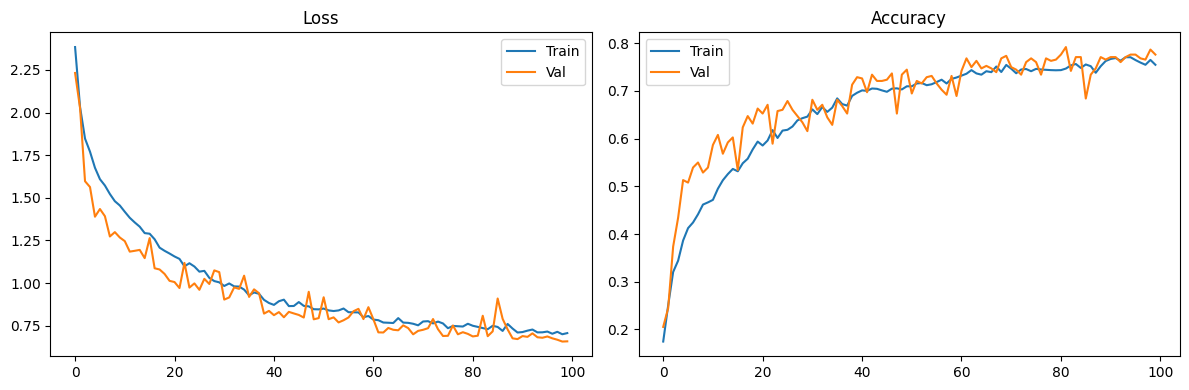

12/12 [==============================] - 0s 21ms/step

Test Accuracy: 80.00%

Classification Report:
              precision    recall  f1-score   support

       blues       0.83      0.89      0.86        38
   classical       0.84      0.95      0.89        38
     country       0.70      0.55      0.62        38
       disco       0.72      0.70      0.71        37
      hiphop       0.84      0.84      0.84        38
        jazz       0.87      0.85      0.86        39
       metal       0.90      0.92      0.91        38
         pop       0.81      0.89      0.85        38
      reggae       0.91      0.82      0.86        38
        rock       0.56      0.58      0.57        38

    accuracy                           0.80       380
   macro avg       0.80      0.80      0.80       380
weighted avg       0.80      0.80      0.80       380



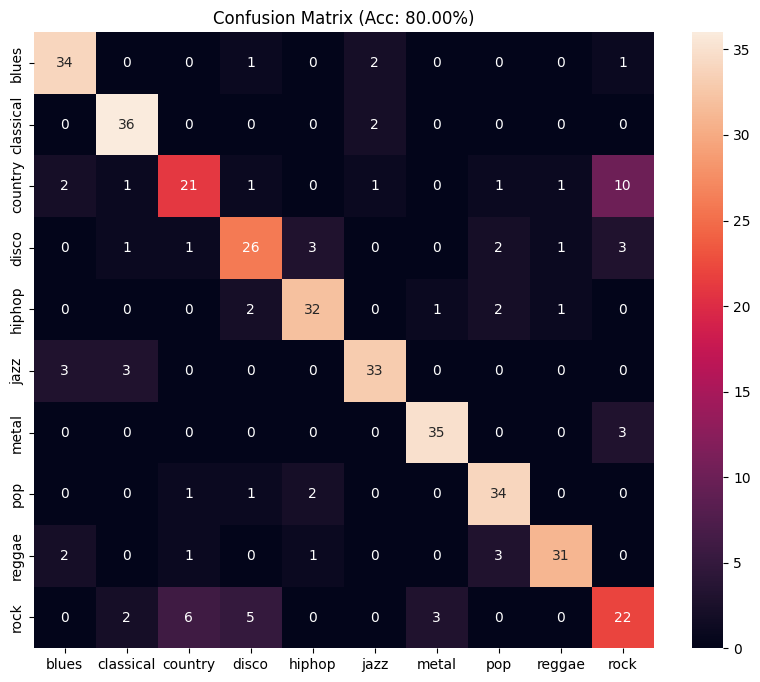

In [ ]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Val')
ax1.set_title('Loss'); ax1.legend()
ax2.plot(history.history['accuracy'], label='Train')
ax2.plot(history.history['val_accuracy'], label='Val')
ax2.set_title('Accuracy'); ax2.legend()
plt.tight_layout()
plt.show()

# Evaluate
y_pred = np.argmax(model.predict(X_test), axis=1)
acc = accuracy_score(y_test, y_pred)
print(f'\nTest Accuracy: {acc:.2%}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=GENRES))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=GENRES, yticklabels=GENRES)
plt.title(f'Confusion Matrix (Acc: {acc:.2%})')
plt.show()

In [ ]:
# Save the complete model (architecture + weights)
model.save('/Users/narac0503/GIT/GTZAN Dataset Classification/GTZAN-Dataset-Classification/gtzan-classification/models/cnn_attention_model.keras')

# Or save in TensorFlow SavedModel format
model.save('/Users/narac0503/GIT/GTZAN Dataset Classification/GTZAN-Dataset-Classification/gtzan-classification/models/cnn_attention_model_savedmodel', save_format='tf')

# Alternative: Save only the weights
model.save_weights('/Users/narac0503/GIT/GTZAN Dataset Classification/GTZAN-Dataset-Classification/gtzan-classification/models/cnn_attention_weights.weights.h5')

print("Model saved successfully!")

INFO:tensorflow:Assets written to: /Users/narac0503/GIT/GTZAN Dataset Classification/GTZAN-Dataset-Classification/gtzan-classification/models/cnn_attention_model_savedmodel/assets


INFO:tensorflow:Assets written to: /Users/narac0503/GIT/GTZAN Dataset Classification/GTZAN-Dataset-Classification/gtzan-classification/models/cnn_attention_model_savedmodel/assets


Model saved successfully!
